### 專案主題 : 躺平族之相關分析

### 大綱
1. 動機與分析目的
2. 分析方向及工具
3. 基本資料介紹
4. 資料前處理
    - 留言萃取
    - 斷詞
5. LDA 主題模型
    - 模型建立
    - Pyvis視覺化
6. Text Presentation
7. 使用embedding做NLP任務
8. 社群網絡分析
9. 結論

## 1. 動機與分析目的

### 分析動機：
* 年輕人為何拒絕奮鬥？低消費低生產主義有可能造成國安危機？
* 不再以買房、買車、生小孩為人生目標，「躺平才是唯一的真理」，年輕人對於未來普遍感到失望和無力，探討社會對於躺平現象的接受度和反應
* 分析躺平族現象對經濟活動、就業市場和消費行為的影響（如不消費、低生產），以及它可能對未來經濟發展的影響
* 透過分析PTT閒聊版上的討論，揭露大眾意見的形成與流動過程。分析媒體如何塑造對躺平族的觀點，以及這些觀點在台灣社會中如何傳播與轉變

## 2. 分析方向及工具

### 分析方向
- 主題模型，用來分析輿論主題的類別．

## 3. 基本資料介紹

- 資料來源：文字平台 PTT閒聊板資料
- 資料集：lie-flat.csv
- 關鍵字：躺平族、躺平、不想努力了
- 資料時間：2021-01-01 到 2024-04-18
- 資料量： 625 篇文章

## 4. 資料前處理

套件設定

In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint
from snownlp import SnowNLP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
# 設定字型
FontPath = 'raw_data/SourceHanSansTW-Regular.otf' 

載入資料

In [4]:
ptt = pd.read_csv("./raw_data/Lie-Flat.csv") 
ptt.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,[心得]沒有工作的一年,2023-11-03 14:04:20,sgc056613,China_Drama,因為在FB滑到[沒有工作的一年]給打工人的15大金句\n才開始注意到這部陸劇[沒有工作的一年...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kirenenko"", ...",27.240.162.237,2023-11-04 01:06:31,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30 11:12:41,vikk33,Gossiping,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n新唐人\n\n2.記者署名:\n羅...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Imotucc"", ""c...",118.160.146.219,2021-05-31 01:48:03,ptt


看看有幾篇文章

In [5]:
print(f"number of posts: {ptt.shape[0]}")
print(f"date range: {(ptt['artDate'].min(), ptt['artDate'].max())}")
print(f"category: \n{ptt['artCatagory'].value_counts()}")


number of posts: 625
date range: ('2021-05-30 11:12:41', '2024-04-15 19:46:25')
category: 
artCatagory
Gossiping      618
prozac           4
China_Drama      2
job              1
Name: count, dtype: int64


清除網址及留下中文字

In [7]:
ptt["artContent"] = ptt["artContent"].str.replace("(http|https)://.*", "", regex=True)
ptt["artContent"] = ptt["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ptt["artTitle"] = ptt["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ptt["artTitle"] = ptt["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ptt["cmtContent"] = ptt["cmtContent"].str.replace("(http|https)://.*", "", regex=True)
ptt["cmtContent"] = ptt["cmtContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ptt.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,cmtContent
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,閒聊沒有工作的一年,2022-05-03 19:54:49,vincentwjs,China_Drama,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,對辣目在演員請就位第二季的表演印象深刻我覺得戲太多了像玉桃花也沒人開討論串不是每檔劇都有人開...
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,心得沒有工作的一年,2023-11-03 14:04:20,sgc056613,China_Drama,因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年總共也才集本來只是...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kirenenko"", ...",27.240.162.237,2023-11-04 01:06:31,ptt,感覺是療癒的輕鬆小品謝謝分享
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,新聞中國人躺平火爆網路當局慌忙喊停,2021-05-30 11:12:41,vikk33,Gossiping,備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷完整新聞標題中國人躺平火爆網路當局...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Imotucc"", ""c...",118.160.146.219,2021-05-31 01:48:03,ptt,停台灣年輕人領先十年對岸比較誇張台灣更多這躺平主義怎麼像在講台灣呢日本的無欲社會也差不多大概...


將 `artTitle`, `artContent`, `cmtContent` 合併成新欄位 `whole_content`

In [8]:
ptt["whole_content"] = ptt["artTitle"] + ptt["artContent"] + ptt["cmtContent"]
ptt = ptt[['system_id', 'artUrl', 'artDate', 'artCatagory', 'whole_content']]

In [9]:
ptt

,system_id,artUrl,artDate,artCatagory,whole_content
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03 19:54:49,China_Drama,閒聊沒有工作的一年都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有...
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,2023-11-03 14:04:20,China_Drama,心得沒有工作的一年因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,2021-05-30 11:12:41,Gossiping,新聞中國人躺平火爆網路當局慌忙喊停備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷...
3,4,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,2021-06-04 20:36:41,Gossiping,問卦我就爛有另一種說法嗎在日本有草食男或啃老族現在中國忽然來了一個躺平族那有沒有其他的說法比...
4,5,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,2021-06-06 18:30:04,Gossiping,問卦具體來說現在在等什麼依據人性人是自私的自己的利益優先考量別人的不幸甜如蜜但是大家在等的都...
...,...,...,...,...,...
618,619,https://www.ptt.cc/bbs/Gossiping/M.1713145120....,2024-04-15 09:38:37,Gossiping,新聞台灣年輕人為何效忠躺平主義網紅台灣年輕人為何效忠躺平主義網紅精闢解析大原因壹蘋記者李雅欣...
619,620,https://www.ptt.cc/bbs/Gossiping/M.1713181587....,2024-04-15 19:46:25,Gossiping,新聞兒科醫臨嚴重人力荒年後重症恐無人治兒科真的這麼慘台大是怎麼收到位住院醫師的兒科確實賺不到...
620,621,https://www.ptt.cc/bbs/job/M.1641443264.A.EF6....,2022-01-06 12:27:42,job,台北徳勝科技徵行政助理版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同...
623,624,https://www.ptt.cc/bbs/prozac/M.1667221824.A.6...,2022-10-31 21:10:21,prozac,閒聊人生的意義就是存活很好但是呢躺平族還是很累的要計算最少金錢得到最均衡的養分活著而且生病很...


### 斷詞

設定字典

In [10]:
jieba.set_dictionary('./dict/dict.txt')
jieba.load_userdict('./dict/user_dict.txt')

Building prefix dict from /Users/wuanjie/Desktop/Text_mining/Social_analysis/Lie_Flat_Project/dict/dict.txt ...
2024-05-30 10:07:14,533 : DEBUG : Building prefix dict from /Users/wuanjie/Desktop/Text_mining/Social_analysis/Lie_Flat_Project/dict/dict.txt ...
Dumping model to file cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.u09bf1d45a751f1e86dbfe5f3f1e92730.cache
2024-05-30 10:07:15,772 : DEBUG : Dumping model to file cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.u09bf1d45a751f1e86dbfe5f3f1e92730.cache
Loading model cost 1.788 seconds.
2024-05-30 10:07:16,332 : DEBUG : Loading model cost 1.788 seconds.
Prefix dict has been built successfully.
2024-05-30 10:07:16,334 : DEBUG : Prefix dict has been built successfully.


In [11]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")


# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    if not isinstance(row, str):  # 檢查類型是否為字串
        row = str(row)  # 將非字串類型轉換為字串
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ptt["words"] = ptt["whole_content"].apply(getToken)
ptt

Building prefix dict from /Users/wuanjie/Desktop/Text_mining/Social_analysis/Lie_Flat_Project/dict/dict.txt ...
2024-05-30 10:07:16,553 : DEBUG : Building prefix dict from /Users/wuanjie/Desktop/Text_mining/Social_analysis/Lie_Flat_Project/dict/dict.txt ...
Loading model from cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.u09bf1d45a751f1e86dbfe5f3f1e92730.cache
2024-05-30 10:07:16,559 : DEBUG : Loading model from cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.u09bf1d45a751f1e86dbfe5f3f1e92730.cache


Loading model cost 2.088 seconds.
2024-05-30 10:07:18,647 : DEBUG : Loading model cost 2.088 seconds.
Prefix dict has been built successfully.
2024-05-30 10:07:18,655 : DEBUG : Prefix dict has been built successfully.


,system_id,artUrl,artDate,artCatagory,whole_content,words
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03 19:54:49,China_Drama,閒聊沒有工作的一年都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有...,"[閒聊, 工作, 第集, 沒人開, 這一, 閒聊, 一部, 顛覆, 都市, 情感, 富美, ..."
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,2023-11-03 14:04:20,China_Drama,心得沒有工作的一年因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年...,"[心得, 工作, 滑到, 工作, 打工, 金句, 注意到, 這部, 陸劇, 工作, 總共, ..."
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,2021-05-30 11:12:41,Gossiping,新聞中國人躺平火爆網路當局慌忙喊停備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷...,"[中國人, 躺平, 火爆, 網路, 當局, 慌忙, 喊停, 備註, 請放, 違者, 刪除, ..."
3,4,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,2021-06-04 20:36:41,Gossiping,問卦我就爛有另一種說法嗎在日本有草食男或啃老族現在中國忽然來了一個躺平族那有沒有其他的說法比...,"[問卦, 就爛, 說法, 草食, 啃老族, 躺平, 說法, 文雅, 八卦, 配上, 嘲諷, ..."
4,5,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,2021-06-06 18:30:04,Gossiping,問卦具體來說現在在等什麼依據人性人是自私的自己的利益優先考量別人的不幸甜如蜜但是大家在等的都...,"[問卦, 具體, 人性, 自私, 利益, 優先, 考量, 不幸, 甜如蜜, 中產階級, 打到..."
...,...,...,...,...,...,...
618,619,https://www.ptt.cc/bbs/Gossiping/M.1713145120....,2024-04-15 09:38:37,Gossiping,新聞台灣年輕人為何效忠躺平主義網紅台灣年輕人為何效忠躺平主義網紅精闢解析大原因壹蘋記者李雅欣...,"[台灣, 年輕人, 效忠, 躺平, 主義, 網紅, 台灣, 年輕人, 效忠, 躺平, 主義,..."
619,620,https://www.ptt.cc/bbs/Gossiping/M.1713181587....,2024-04-15 19:46:25,Gossiping,新聞兒科醫臨嚴重人力荒年後重症恐無人治兒科真的這麼慘台大是怎麼收到位住院醫師的兒科確實賺不到...,"[兒科, 醫臨, 嚴重, 人力荒, 重症, 恐無人治, 兒科, 台大, 收到, 住院, 醫師..."
620,621,https://www.ptt.cc/bbs/job/M.1641443264.A.EF6....,2022-01-06 12:27:42,job,台北徳勝科技徵行政助理版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同...,"[台北, 徳勝, 科技, 行政, 助理, 禁止, 張貼, 違反, 就業, 服務法, 性別, ..."
623,624,https://www.ptt.cc/bbs/prozac/M.1667221824.A.6...,2022-10-31 21:10:21,prozac,閒聊人生的意義就是存活很好但是呢躺平族還是很累的要計算最少金錢得到最均衡的養分活著而且生病很...,"[閒聊, 人生, 意義, 存活, 躺平, 很累, 計算, 最少, 金錢, 得到, 均衡, 養..."


## 5. LDA 主題模型

In [12]:
docs = ptt['words'].to_list()

In [13]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-05-30 10:07:47,102 : INFO : adding document #0 to Dictionary<0 unique tokens: []>


2024-05-30 10:07:47,700 : INFO : built Dictionary<25536 unique tokens: ['一部', '主角', '也許', '人生', '人設']...> from 618 documents (total 128425 corpus positions)
2024-05-30 10:07:47,739 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<25536 unique tokens: ['一部', '主角', '也許', '人生', '人設']...> from 618 documents (total 128425 corpus positions)", 'datetime': '2024-05-30T10:07:47.739162', 'gensim': '4.3.2', 'python': '3.11.4 (v3.11.4:d2340ef257, Jun  6 2023, 19:15:51) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-12.5-x86_64-i386-64bit', 'event': 'created'}
2024-05-30 10:07:47,789 : INFO : discarding 22019 tokens: [('一部', 1), ('主角', 3), ('人設', 3), ('人開', 2), ('代入', 1), ('候選', 1), ('劇王', 1), ('北上', 2), ('受挫', 2), ('大雨', 2)]...
2024-05-30 10:07:47,794 : INFO : keeping 3517 tokens which were in no less than 5 and no more than 611 (=99.0%) documents
2024-05-30 10:07:47,823 : INFO : resulting dictionary: Dictionary<3517 unique tokens: ['也許', '人生', '今年', '兩人', '加入']...>


Dictionary<3517 unique tokens: ['也許', '人生', '今年', '兩人', '加入']...>


In [14]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

也許: 0
人生: 1
今年: 2
兩人: 3
加入: 4
北漂: 5
印象: 6
可愛: 7
喜歡: 8
太多: 9
失業: 10
好看: 11


In [15]:
pprint(" ".join(ptt['words'].iloc[600]))

('問卦 房價 無限 上漲 沒錯 事實 先買 先贏 確定 要當 躺平 新莊 交界 泰山 溫仔 重劃區 房價 疫情 前約 新建案 喊到 字頭 此區 房子 新舊 '
 '均價 房價 上漲 先買 先贏 朋友 從字頭 本來 觀望 字頭 房價 喊空 老師 信心 喊話 沒關係 這幾年 房市 笑呵呵 還在 明年 房價 選對 選完 '
 '炒接 盤俠 上車')


In [16]:
dictionary.doc2bow(ptt['words'].iloc[600])[:10]

[(48, 1),
 (56, 1),
 (88, 1),
 (185, 5),
 (291, 1),
 (311, 1),
 (341, 1),
 (419, 1),
 (543, 1),
 (605, 1)]

In [17]:
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

corpus[0][:3]

[(0, 2), (1, 1), (2, 1)]

#### 建立模型
**透過指標找出最佳主題數**

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 2048,
        alpha=0.02,
        eta=0.1,
        iterations=1000,
        passes=20 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

In [ ]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,1922.066478,-0.008502
1,3,1850.404630,-0.037429
2,4,1861.939292,-0.045777
3,5,1862.957401,-0.031736
4,6,1868.183767,-0.031344
5,7,1872.868483,-0.030778
6,8,1876.499694,-0.049242
7,9,1866.766215,-0.026925


<Axes: xlabel='topic_num'>

2024-05-17 21:18:21,094 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 21:18:21,111 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 21:18:21,113 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 21:18:21,117 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 21:18:21,119 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 21:18:21,122 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 21:18:21,126 : WARNING : findfont: Generic family 'sans-serif' no

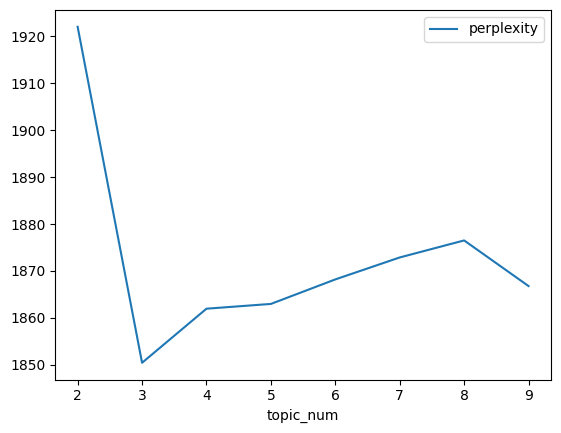

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

2024-05-17 21:18:21,874 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 21:18:21,877 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 21:18:21,880 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 21:18:21,883 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 21:18:21,887 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 21:18:21,890 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
2024-05-17 21:18:21,897 : WARNING : findfont: Generic family 'sans-serif' no

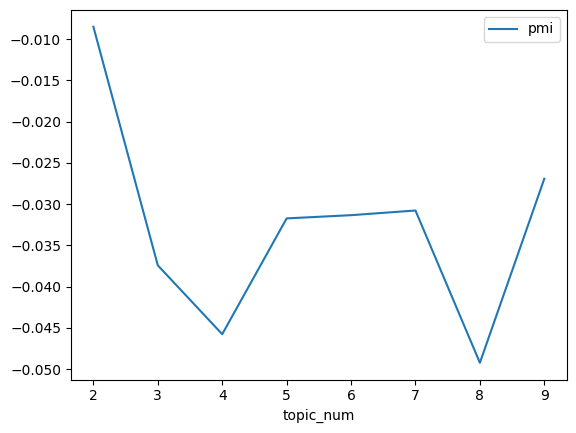

In [ ]:
result.plot.line(x='topic_num', y='pmi')

### 視覺化呈現

-  選擇topic=3

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 3,
    id2word=dictionary,
    random_state = 2048,
    alpha=0.02,
    eta=0.1,
    iterations=1000,
    passes=20 # 訓練次數
    )

2024-05-17 21:18:22,731 : INFO : using serial LDA version on this node
2024-05-17 21:18:22,743 : INFO : running online (multi-pass) LDA training, 3 topics, 20 passes over the supplied corpus of 618 documents, updating model once every 618 documents, evaluating perplexity every 618 documents, iterating 1000x with a convergence threshold of 0.001000
2024-05-17 21:18:26,101 : INFO : -8.826 per-word bound, 453.8 perplexity estimate based on a held-out corpus of 618 documents with 88060 words
2024-05-17 21:18:26,102 : INFO : PROGRESS: pass 0, at document #618/618
2024-05-17 21:18:28,551 : INFO : topic #0 (0.020): 0.010*"買房" + 0.010*"台灣" + 0.009*"年輕人" + 0.007*"房價" + 0.007*"年級" + 0.006*"工作" + 0.006*"房子" + 0.006*"政府" + 0.006*"努力" + 0.006*"專家"
2024-05-17 21:18:28,552 : INFO : topic #1 (0.020): 0.020*"台灣" + 0.010*"房價" + 0.009*"年輕人" + 0.008*"工作" + 0.008*"買房" + 0.008*"政府" + 0.007*"房子" + 0.006*"努力" + 0.006*"經濟" + 0.006*"社會"
2024-05-17 21:18:28,556 : INFO : topic #2 (0.020): 0.017*"工作" + 0.008*"努力" 

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.041042 -0.098305       1        1  48.712362
2     -0.147974  0.025411       2        1  29.605890
0      0.106932  0.072895       3        1  21.681747, topic_info=     Term        Freq       Total Category  logprob  loglift
12     工作  854.000000  854.000000  Default  30.0000  30.0000
1004   年級  359.000000  359.000000  Default  29.0000  29.0000
417    放棄  207.000000  207.000000  Default  28.0000  28.0000
892   八年級  200.000000  200.000000  Default  27.0000  27.0000
991   七年級  178.000000  178.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
48     房子  103.659887  625.585618   Topic3  -5.2160  -0.2689
395    不生   84.196073  328.158860   Topic3  -5.4239   0.1683
1265  民進黨   77.798816  290.941483   Topic3  -5.5029   0.2097
201    政府   76.594747  566.712669   Topic3  -5.5185  -0.4726
509    垃圾   72.152951  233.208571   Topic3  -5.5783   0.3556

[268 rows x 6 columns], token_table=      Topic      Freq Term
term                      
475       1  0.203982   一代
475       2  0.731936   一代
475       3  0.071994   一代
991       1  0.028017  七年級
991       2  0.028017  七年級
...     ...       ...  ...
826       1  0.995917   香港
2606      1  0.928298   高雄
2606      2  0.034811   高雄
2606      3  0.034811   高雄
3515      2  0.983589   鷹架

[421 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [ ]:
pyLDAvis.save_html(p, "lda_zh.html")

### 主題分析
| 主題 | 關鍵字 | 主題議題 | 
| --- | --- | --- | 
| 1 | 年輕人、房價、炒房、買房、買不起、薪資、未來 | 圍繞著年輕人和房地產市場的挑戰。關鍵議題包括高房價和炒房問題，使得年輕人難以負擔購房。議題還涉及到薪資水平與房價的巨大差距，導致年輕人對未來的擔憂和不確定性。 | 
| 2 | 工作、小孩、上班、生活、結婚、賺錢、不婚、人生 | 涉及工作與生活的平衡，尤其是對於已經有小孩或準備要小孩的家庭。議題包含結婚和不婚的選擇，工作和賺錢的壓力，以及這些因素對個人生活品質的影響。 | 
| 3 | 年紀、七年級、八年級、努力、經濟、房貸、存款、學生 | 探討不同年齡層，特別是七年級和八年級生在經濟壓力下的生活。議題包括努力工作賺錢、經濟狀況、償還房貸和存款的挑戰。還涉及到學生時期的經濟壓力和對未來的準備。 | 


#### 時間分佈

In [ ]:
# 轉換時間格式
topic_ptt['artDate'] = pd.to_datetime(topic_ptt['artDate'])
topic_ptt["artDate"] = topic_ptt["artDate"].dt.date


In [ ]:
topic_ptt.head()

,system_id,artUrl,artDate,artCatagory,whole_content,words,topic
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03,China_Drama,閒聊沒有工作的一年都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有...,"[閒聊, 工作, 第集, 沒人開, 這一, 閒聊, 一部, 顛覆, 都市, 情感, 富美, ...",3
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,2023-11-03,China_Drama,心得沒有工作的一年因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年...,"[心得, 工作, 滑到, 工作, 打工, 金句, 注意到, 這部, 陸劇, 工作, 總共, ...",3
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,2021-05-30,Gossiping,新聞中國人躺平火爆網路當局慌忙喊停備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷...,"[中國人, 躺平, 火爆, 網路, 當局, 慌忙, 喊停, 備註, 請放, 違者, 刪除, ...",2
3,4,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,2021-06-04,Gossiping,問卦我就爛有另一種說法嗎在日本有草食男或啃老族現在中國忽然來了一個躺平族那有沒有其他的說法比...,"[問卦, 就爛, 說法, 草食, 啃老族, 躺平, 說法, 文雅, 八卦, 配上, 嘲諷, ...",1
4,5,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,2021-06-06,Gossiping,問卦具體來說現在在等什麼依據人性人是自私的自己的利益優先考量別人的不幸甜如蜜但是大家在等的都...,"[問卦, 具體, 人性, 自私, 利益, 優先, 考量, 不幸, 甜如蜜, 中產階級, 打到...",2


In [ ]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':topic_ptt.groupby(['artDate','topic']).size()
})
date_topic = date_topic.reset_index()
date_topic = date_topic.groupby([date_topic['artDate'],'topic']).sum().reset_index()

In [ ]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic1', 'topic2','topic3']
date_df

,artDate,topic1,topic2,topic3
0,2021-05-30,0.0,1.0,0.0
1,2021-06-04,1.0,0.0,0.0
2,2021-06-06,0.0,1.0,0.0
3,2021-06-18,1.0,0.0,0.0
4,2021-06-27,0.0,0.0,1.0
...,...,...,...,...
324,2024-02-11,0.0,1.0,0.0
325,2024-02-21,0.0,1.0,0.0
326,2024-03-30,1.0,0.0,0.0
327,2024-03-31,1.0,0.0,0.0


In [ ]:
pickDate_df = date_df.copy()
pickDate_df['total'] = pickDate_df.apply(lambda x: x['topic1']+x['topic2']+x['topic3'], axis=1)
pickDate_df.sort_values('total', ascending=False, inplace=True)
index = pickDate_df.head(1).index.values[0]
new_pickDate_df=date_df[index:index+7]
new_pickDate_df

,artDate,topic1,topic2,topic3
23,2021-09-30,16.0,13.0,25.0
24,2021-10-01,5.0,5.0,7.0
25,2021-10-02,1.0,0.0,7.0
26,2021-10-03,1.0,2.0,3.0
27,2021-10-04,0.0,0.0,1.0
28,2021-10-05,0.0,1.0,0.0
29,2021-10-06,0.0,2.0,1.0


- 

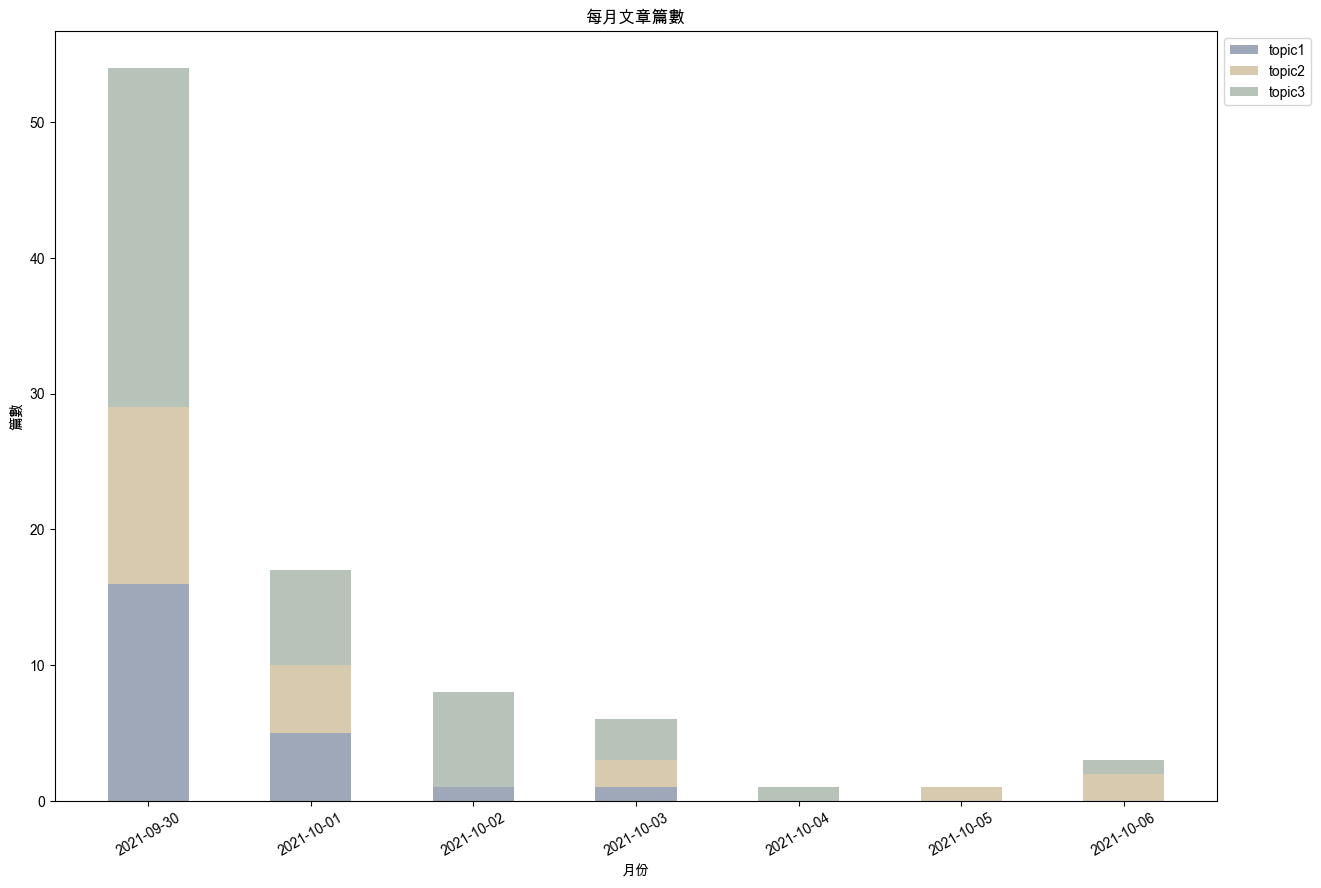

In [ ]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']

plt.subplots(figsize=(15,10))
color = ["#9FA8B9", "#D8CAAF", "#B7C2B8"]
column = ['topic1', 'topic2', 'topic3']
temp_bottom = 0

for i in range(0,3):
    if(i>0):
        temp_bottom = temp_bottom + new_pickDate_df[column[i-1]]
        plt.bar(new_pickDate_df.artDate, new_pickDate_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i] , width=0.5)
    else: # 主題一 bottom 為 0
        plt.bar(new_pickDate_df.artDate, new_pickDate_df[column[i]] ,color=color[i], label=column[i] , width=0.5)
        

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

## 6. Text Presentation

In [ ]:

import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch
sns.set_style("darkgrid")

#### word2vec

In [ ]:
ptt.head()

,system_id,artUrl,artDate,artCatagory,whole_content,words,topic_label
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03 19:54:49,China_Drama,閒聊沒有工作的一年都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有...,"[閒聊, 工作, 第集, 沒人開, 這一, 閒聊, 一部, 顛覆, 都市, 情感, 富美, ...",3
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,2023-11-03 14:04:20,China_Drama,心得沒有工作的一年因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年...,"[心得, 工作, 滑到, 工作, 打工, 金句, 注意到, 這部, 陸劇, 工作, 總共, ...",3
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,2021-05-30 11:12:41,Gossiping,新聞中國人躺平火爆網路當局慌忙喊停備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷...,"[中國人, 躺平, 火爆, 網路, 當局, 慌忙, 喊停, 備註, 請放, 違者, 刪除, ...",2
3,4,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,2021-06-04 20:36:41,Gossiping,問卦我就爛有另一種說法嗎在日本有草食男或啃老族現在中國忽然來了一個躺平族那有沒有其他的說法比...,"[問卦, 就爛, 說法, 草食, 啃老族, 躺平, 說法, 文雅, 八卦, 配上, 嘲諷, ...",1
4,5,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,2021-06-06 18:30:04,Gossiping,問卦具體來說現在在等什麼依據人性人是自私的自己的利益優先考量別人的不幸甜如蜜但是大家在等的都...,"[問卦, 具體, 人性, 自私, 利益, 優先, 考量, 不幸, 甜如蜜, 中產階級, 打到...",2


In [ ]:
sents = ptt['words'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
ptt['word_list_bigrams'] = list(bigram_phrasers[sents])

ptt.head()

2024-05-17 21:46:06,546 : INFO : collecting all words and their counts
2024-05-17 21:46:06,548 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2024-05-17 21:46:07,131 : INFO : collected 134476 token types (unigram + bigrams) from a corpus of 128425 words and 618 sentences
2024-05-17 21:46:07,134 : INFO : merged Phrases<134476 vocab, min_count=1, threshold=1000, max_vocab_size=40000000>
2024-05-17 21:46:07,136 : INFO : Phrases lifecycle event {'msg': 'built Phrases<134476 vocab, min_count=1, threshold=1000, max_vocab_size=40000000> in 0.59s', 'datetime': '2024-05-17T21:46:07.136414', 'gensim': '4.3.2', 'python': '3.11.4 (v3.11.4:d2340ef257, Jun  6 2023, 19:15:51) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-12.5-x86_64-i386-64bit', 'event': 'created'}
2024-05-17 21:46:07,140 : INFO : exporting phrases from Phrases<134476 vocab, min_count=1, threshold=1000, max_vocab_size=40000000>
2024-05-17 21:46:07,402 : INFO : FrozenPhrases lifecycle event {'msg': 'e

,system_id,artUrl,artDate,artCatagory,whole_content,words,topic_label,word_list_bigrams
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03 19:54:49,China_Drama,閒聊沒有工作的一年都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有...,"[閒聊, 工作, 第集, 沒人開, 這一, 閒聊, 一部, 顛覆, 都市, 情感, 富美, ...",3,"[閒聊, 工作, 第集, 沒人開, 這一, 閒聊, 一部, 顛覆, 都市, 情感, 富美, ..."
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,2023-11-03 14:04:20,China_Drama,心得沒有工作的一年因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年...,"[心得, 工作, 滑到, 工作, 打工, 金句, 注意到, 這部, 陸劇, 工作, 總共, ...",3,"[心得, 工作, 滑到, 工作, 打工, 金句, 注意到, 這部, 陸劇, 工作, 總共, ..."
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,2021-05-30 11:12:41,Gossiping,新聞中國人躺平火爆網路當局慌忙喊停備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷...,"[中國人, 躺平, 火爆, 網路, 當局, 慌忙, 喊停, 備註, 請放, 違者, 刪除, ...",2,"[中國人, 躺平, 火爆, 網路, 當局_慌忙, 喊停, 備註_請放, 違者_刪除, 來源,..."
3,4,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,2021-06-04 20:36:41,Gossiping,問卦我就爛有另一種說法嗎在日本有草食男或啃老族現在中國忽然來了一個躺平族那有沒有其他的說法比...,"[問卦, 就爛, 說法, 草食, 啃老族, 躺平, 說法, 文雅, 八卦, 配上, 嘲諷, ...",1,"[問卦, 就爛, 說法, 草食, 啃老族, 躺平, 說法, 文雅, 八卦, 配上, 嘲諷, ..."
4,5,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,2021-06-06 18:30:04,Gossiping,問卦具體來說現在在等什麼依據人性人是自私的自己的利益優先考量別人的不幸甜如蜜但是大家在等的都...,"[問卦, 具體, 人性, 自私, 利益, 優先, 考量, 不幸, 甜如蜜, 中產階級, 打到...",2,"[問卦, 具體, 人性, 自私, 利益, 優先, 考量, 不幸, 甜如蜜, 中產階級, 打到..."


In [ ]:
word_freq = defaultdict(int)
# 計算詞頻
sents = ptt['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1
     

In [ ]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 26231


['躺平', '台灣', '工作', '買房', '年輕人', '房價', '房子', '努力', '政府', '社會']

In [ ]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 618
average length of sentences: 201.85760517799352


In [ ]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 4


In [ ]:

# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     #  negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

2024-05-17 21:47:13,340 : INFO : collecting all words and their counts
2024-05-17 21:47:13,356 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-05-17 21:47:13,427 : INFO : collected 26231 word types from a corpus of 124748 raw words and 618 sentences
2024-05-17 21:47:13,429 : INFO : Creating a fresh vocabulary
2024-05-17 21:47:13,444 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=30 retains 667 unique words (2.54% of original 26231, drops 25564)', 'datetime': '2024-05-17T21:47:13.444036', 'gensim': '4.3.2', 'python': '3.11.4 (v3.11.4:d2340ef257, Jun  6 2023, 19:15:51) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-12.5-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2024-05-17 21:47:13,445 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=30 leaves 57257 word corpus (45.90% of original 124748, drops 67491)', 'datetime': '2024-05-17T21:47:13.445640', 'gensim': '4.3.2', 'python': '3.11.4 (v3.11.4:d2340ef257, Jun  6 2023,

In [ ]:
# 檢查最相關的字
w2v_model.wv.most_similar('躺平',topn=10)

[('問卦', 0.9680317640304565),
 ('啃老', 0.8851193189620972),
 ('舒服', 0.8734372854232788),
 ('八卦', 0.8707281351089478),
 ('床上', 0.8699026703834534),
 ('草莓族', 0.8656585812568665),
 ('八年級', 0.8653789758682251),
 ('台女', 0.8611111640930176),
 ('七年級', 0.8609461784362793),
 ('賺錢', 0.8607584834098816)]

In [ ]:
w2v_model.wv.most_similar('房價',topn=10)

[('打房', 0.9148802161216736),
 ('炒房', 0.9066422581672668),
 ('政府', 0.8951968550682068),
 ('垃圾', 0.8830729722976685),
 ('建商', 0.8711075782775879),
 ('民進黨', 0.8669833540916443),
 ('通膨', 0.8612779974937439),
 ('死忠', 0.8594090938568115),
 ('藍綠', 0.8584507703781128),
 ('年輕人', 0.8479766249656677)]

In [ ]:

w2v_model.wv.most_similar(['躺平','房價'],topn=10)

[('老人', 0.9278573393821716),
 ('少子化', 0.9249099493026733),
 ('未來', 0.921909511089325),
 ('抱怨', 0.9208036065101624),
 ('草莓', 0.9153416752815247),
 ('世代', 0.9143086671829224),
 ('網路', 0.9123998284339905),
 ('乖乖', 0.9115209579467773),
 ('草莓族', 0.9113165140151978),
 ('內文', 0.9107744693756104)]

In [ ]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

In [ ]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat

In [ ]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)


In [ ]:

getVecs(w2v_model,['躺平','房價'])

array([[ 0.09506601,  0.1189841 ,  0.14376631,  0.37026307,  0.23565944,
        -0.16758558,  0.17551829,  0.20865019,  0.12218142,  0.07426232,
         0.02447679, -0.19900051, -0.08837251, -0.10807537, -0.17036028,
         0.23361672,  0.22190261, -0.058365  ,  0.11287185,  0.30225757,
         0.11076736,  0.13253288,  0.07867872,  0.12177174, -0.06981584,
         0.27793667,  0.14580883, -0.00947381,  0.12778935,  0.06349357,
         0.26405236,  0.09113877, -0.03290614,  0.07726349,  0.13097788,
        -0.14176254, -0.07946181, -0.37844628, -0.10813768, -0.04175407,
         0.28960267, -0.3279676 ,  0.00878085,  0.13175656, -0.15756637,
         0.10231344, -0.00510486,  0.5658182 ,  0.15996729, -0.17724945,
         0.41109195,  0.01594985, -0.3074663 , -0.00739243, -0.0500479 ,
        -0.2778676 , -0.20633231, -0.16722938, -0.15951324,  0.17628378,
        -0.13148402,  0.06943754, -0.14022362,  0.27031758,  0.1634343 ,
        -0.09599836,  0.18811002,  0.10068698,  0.1

In [ ]:
# 擴展相似的字詞
def expandPosWord(model,words:list,top_n:int,split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])
    return list(set(expand))

In [ ]:
expandPosWord(w2v_model,['躺平','年輕人'],top_n = 10)

['台灣',
 '啃老',
 '床上',
 '八年級',
 '八卦',
 '問卦',
 '少子化',
 '低薪',
 '飆漲',
 '經濟',
 '七年級',
 '未來',
 '賺錢',
 '房價',
 '台女',
 '高房價',
 '老人',
 '舒服',
 '草莓族',
 '死忠']

In [ ]:
from matplotlib.font_manager import fontManager
import plotly.express as px
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()
# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [ ]:
sample_words = np.random.choice(list(words),300,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [ ]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

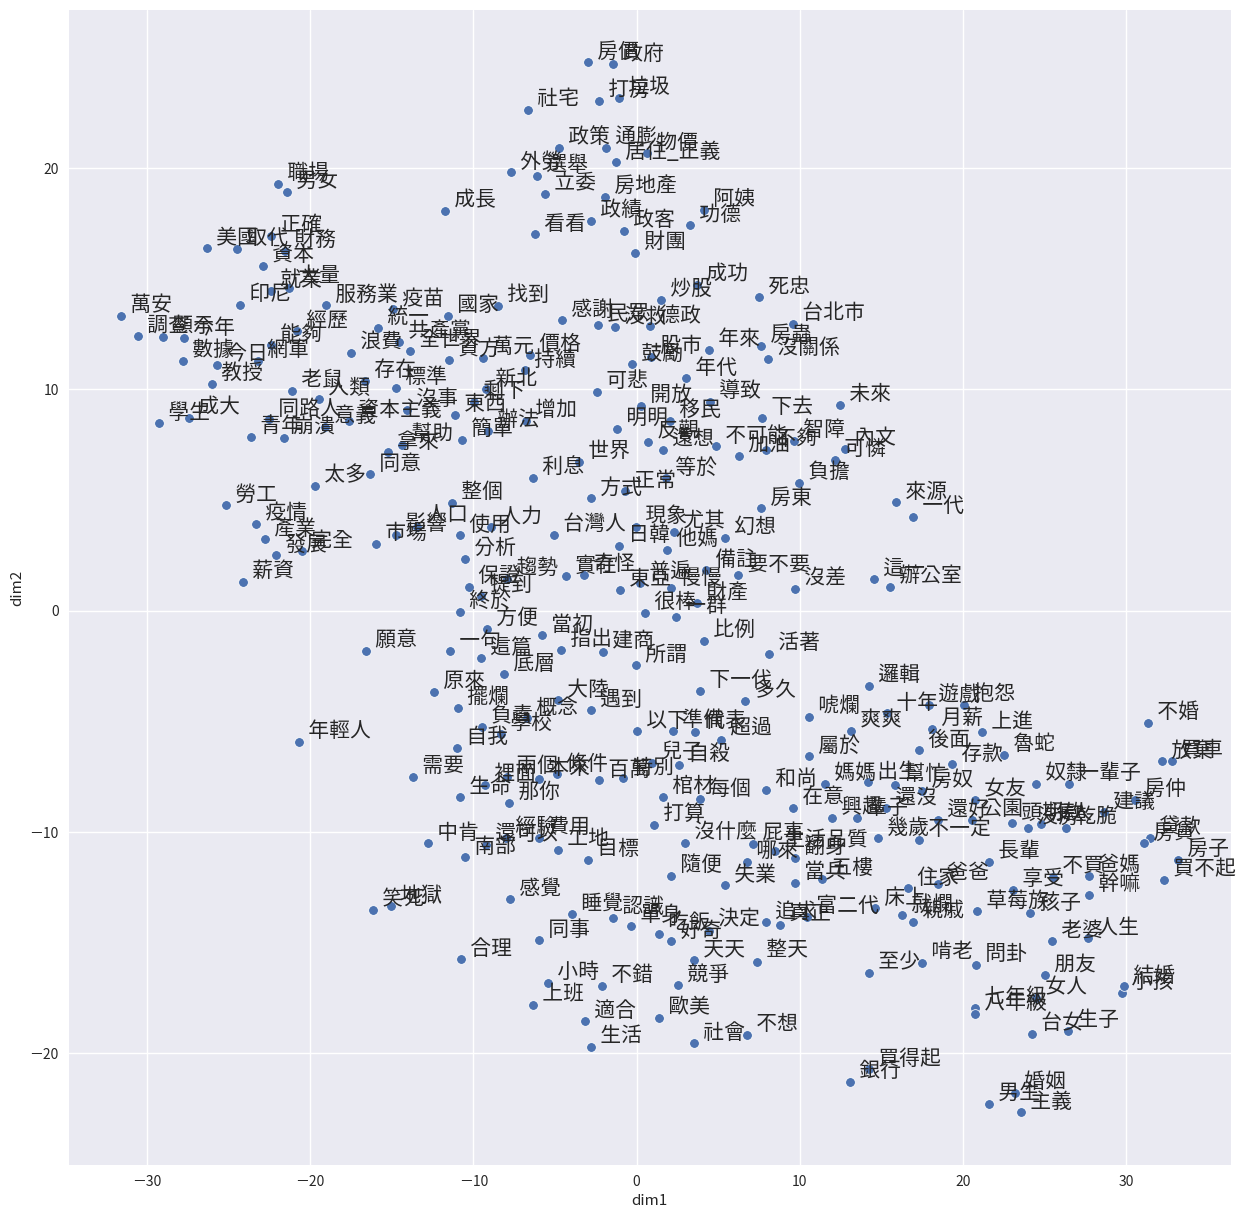

In [ ]:
plotScatter(word_df)

## 7.使用embedding做NLP任務

相似文件

In [ ]:
origin_data = pd.read_csv("./raw_data/Lie-Flat.csv") 

In [ ]:
df_similar = origin_data[['system_id','artTitle', 'artContent']]
df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_similar.head(5)

/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_57390/852741673.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,system_id,artTitle,artContent
0,1,[閒聊]沒有工作的一年~~,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...
1,2,[心得]沒有工作的一年,因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年總共也才集本來只是...
2,3,[新聞]中國人「躺平」火爆網路當局慌忙喊停,備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷完整新聞標題中國人躺平火爆網路當局...
3,4,[問卦]我就爛有另一種說法嗎?,在日本有草食男或啃老族現在中國忽然來了一個躺平族那有沒有其他的說法比較文雅的有沒有八卦
4,5,Re:[問卦]具體來說現在在等什麼,依據人性人是自私的自己的利益優先考量別人的不幸甜如蜜但是大家在等的都不一樣所以中產階級在等我...


In [ ]:
from sentence_transformers import SentenceTransformer

# 選擇並加載模型
model = SentenceTransformer('bert-base-chinese')

2024-05-17 22:11:07,448 : INFO : Load pretrained SentenceTransformer: bert-base-chinese
2024-05-17 22:11:07,887 : WARNING : No sentence-transformers model found with name bert-base-chinese. Creating a new one with MEAN pooling.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

2024-05-17 22:11:36,030 : INFO : Use pytorch device_name: cpu


In [ ]:
from sentence_transformers import SentenceTransformer, models, util

In [ ]:
corpus_embeddings = model.encode(df_similar['artContent'], convert_to_tensor=True)

query_num = 6 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = model.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]





Query: Re:[問卦]現今社會啃老多嗎?

 資料集中前五相似的文章:
Re:[問卦]現今社會啃老多嗎? (Score: 1.0000)
[問卦]極簡主義者是不是比躺平族潮 (Score: 0.9352)
[問卦]我就爛有另一種說法嗎? (Score: 0.9299)
[問卦]歐美有躺平族嗎? (Score: 0.9293)
Re:[問卦]日本年輕人才是草莓族吧 (Score: 0.9287)






In [ ]:
query_num = 12

query_embedding = model.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]





Query: [新聞]8年級竄出大量躺平族！鄉民「不婚不生」

 資料集中前五相似的文章:
[新聞]8年級竄出大量躺平族！鄉民「不婚不生」 (Score: 1.0000)
[新聞]8年級竄出大量躺平族！鄉民「不婚不生」 (Score: 0.9986)
[新聞]8年級湧大量「躺平族」！不婚不生放棄掙 (Score: 0.9915)
[新聞]「躺平族」已成時代趨勢網曝4大軟爛類型 (Score: 0.9891)
[新聞]草莓族落伍了！全新「躺平族」特徵曝光 (Score: 0.9872)






## 8.社群網絡分析

In [21]:
raw_data=pd.read_csv("./raw_data/Lie-Flat.csv") 
raw_data.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,[心得]沒有工作的一年,2023-11-03 14:04:20,sgc056613,China_Drama,因為在FB滑到[沒有工作的一年]給打工人的15大金句\n才開始注意到這部陸劇[沒有工作的一年...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kirenenko"", ...",27.240.162.237,2023-11-04 01:06:31,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30 11:12:41,vikk33,Gossiping,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n新唐人\n\n2.記者署名:\n羅...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Imotucc"", ""c...",118.160.146.219,2021-05-31 01:48:03,ptt
3,4,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,[問卦]我就爛有另一種說法嗎?,2021-06-04 20:36:41,eric112,Gossiping,在日本有草食男或啃老族\n\n現在中國忽然來了一個躺平族\n\n那有沒有其他的說法比較文雅的...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""makinoyui"", ...",36.227.134.238,2021-06-05 01:20:55,ptt
4,5,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,Re:[問卦]具體來說現在在等什麼,2021-06-06 18:30:04,leondemon,Gossiping,依據人性\n\n1. 人是自私的，自己的利益優先考量\n2. 別人的不幸甜如蜜\n\n但是大...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""jjjjjjs"", ""c...",27.53.17.75,2021-06-07 01:25:44,ptt


In [23]:
##只取有回覆過的文章
raw_data = raw_data[raw_data.artComment != '[]']

##由於文章數量較多，顧取其1/30
raw_data = raw_data.sample(round(raw_data.shape[0]/4))
print(raw_data.shape)
raw_data.head()

(154, 13)


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,artComter,artStatus
423,424,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,Re:[問卦]房價真的對現在的年輕人不公平,2022-12-24 22:12:46,gn02160940,Gossiping,我也七年級尾\n\n但我根本買不起台灣家庭式的房子\n\n普通薪水是要買什麼\n\n但我還是...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""freeclouds"",...",223.136.187.239,2022-12-25 01:32:43,ptt,"[freeclouds, dayend, ayukiu, bigwun73, milosky...","[推, →, 推, →, 推, 噓, →, →, →, →, →, 推, 推, →, →, ..."
35,36,https://www.ptt.cc/bbs/Gossiping/M.1632984122....,Re:[新聞]8年級竄出大量躺平族！鄉民「不婚不生」,2021-09-30 14:41:58,Lineage097,Gossiping,說8年級是躺平族\n\n這個觀念應該錯滿大的\n\n日本還能躺平就算了\n\n你在台灣是能躺...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""marktak"", ""c...",59.127.21.239,2021-10-01 00:36:40,ptt,"[marktak, curlymonkey, labell, rock30106, leon...","[推, 推, →, 推, →, 推, 推, 推, →, 推, 推, →, 推, 推, →, ..."
138,139,https://www.ptt.cc/bbs/Gossiping/M.1634297980....,Re:[問卦]基本工資漲了爽到誰啊,2021-10-15 19:39:35,smileboy2016,Gossiping,認真回\n\n爽到住家裡的萬年打工仔\n\n01012022之後的台灣時薪168/h\n\n...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""sali921"", ""c...",203.204.50.67,2021-10-16 00:40:49,ptt,"[sali921, cerpherus, bestrace, bestrace]","[噓, →, →, →]"
438,439,https://www.ptt.cc/bbs/Gossiping/M.1674395412....,[問卦]以後躺平族過年一個人要幹嘛？,2023-01-22 21:50:10,taot917,Gossiping,現在的親緣越來越淺了\n\n堂哥表哥都不是必需品\n\n加上躺平族不婚不生\n\n\n以後過...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""dear133"", ""c...",61.62.45.248,2023-01-23 01:24:07,ptt,"[dear133, eric19850629, hong414, hong414, citi...","[噓, →, →, →, 推, →, →, 噓, 推, 推, →, 推, →, 推, 噓, 推]"
298,299,https://www.ptt.cc/bbs/Gossiping/M.1647830938....,[問卦]沒人發現躺平根本是一場騙局嗎,2022-03-21 10:48:53,kimura0701,Gossiping,最近幾年很流行什麼躺平族\n\n搞得好像大家都覺得不上進 不積極是正常的\n\n後來才發現別...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""k385476916"",...",220.136.81.11,2022-03-22 00:29:19,ptt,"[k385476916, Usayhiisayha, sbob, chadmu, zithr...","[推, 噓, 推, 推, 噓, →, 推, 噓, 推, →, 推, 推, 噓, 噓, →, ..."


### 8.1 建立發文者(artPoster)與推文者(cmtPoster)的網路圖

In [24]:
def getComtInfo(com):
  cmters,cmt_statuss = [],[]
  com = eval(com)
  for i in com:
    print(i)
    cmters.append(i['cmtPoster'])
    cmt_statuss.append(i['cmtStatus'])
  return pd.Series([cmters, cmt_statuss])

raw_data[['artComter','artStatus']] = raw_data['artComment'].apply(lambda r: getComtInfo(r))

{'cmtStatus': '推', 'cmtPoster': 'freeclouds', 'cmtContent': ':建商也很辛苦還要給政客政治獻金', 'cmtDate': '2022-12-24 22:13:00'}
{'cmtStatus': '→', 'cmtPoster': 'dayend', 'cmtContent': ':講得我靠自己買了房子很有病似的...呵呵', 'cmtDate': '2022-12-24 22:13:00'}
{'cmtStatus': '推', 'cmtPoster': 'ayukiu', 'cmtContent': ':覺得你觀念正確沒必要結婚害另一個人', 'cmtDate': '2022-12-24 22:14:00'}
{'cmtStatus': '→', 'cmtPoster': 'bigwun73', 'cmtContent': ':671887509.A.9D9.html', 'cmtDate': '2022-12-24 22:15:00'}
{'cmtStatus': '推', 'cmtPoster': 'miloskyman', 'cmtContent': ':這六年你過得好嗎~嘻嘻', 'cmtDate': '2022-12-24 22:15:00'}
{'cmtStatus': '噓', 'cmtPoster': 'chunzheng', 'cmtContent': ':你確定你老了還可以貸款買房嗎', 'cmtDate': '2022-12-24 22:15:00'}
{'cmtStatus': '→', 'cmtPoster': 'bigwun73', 'cmtContent': ':載入失敗重傳', 'cmtDate': '2022-12-24 22:16:00'}
{'cmtStatus': '→', 'cmtPoster': 'bigwun73', 'cmtContent': ':這篇你可看看', 'cmtDate': '2022-12-24 22:16:00'}
{'cmtStatus': '→', 'cmtPoster': 's410294', 'cmtContent': ':別這樣說建商他們也是被政客壓榨的一', 'cmtDate': '2022-12-24 22:16:00'}
{

依據每一筆留言展開

In [36]:
raw_data = raw_data.explode(['artComter','artStatus'])
social_data = raw_data[['artUrl','artPoster','artComter','artStatus']]
social_data.head(10)

,artUrl,artPoster,artComter,artStatus
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,freeclouds,推
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,dayend,→
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,ayukiu,推
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,bigwun73,→
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,miloskyman,推
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,chunzheng,噓
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,bigwun73,→
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,bigwun73,→
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,s410294,→
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,s410294,→


建立邊的資料

In [27]:
import random

# 發文者對文章
po_df = socail_data[['artPoster','artUrl']].drop_duplicates().rename(columns = {'artPoster':'src','artUrl':'dis'})

# sample 300 篇文章
random.seed(2024)
sample_url = random.choices(po_df.dis.unique().tolist(),k=300)
po_df = po_df[po_df.dis.isin(sample_url)]

# 留言者對文章，狀態為 weight
re_df = socail_data[['artComter','artUrl','artStatus']].rename(columns = {'artComter':'src','artUrl':'dis','artStatus':'weight'})
re_df = re_df[re_df.dis.isin(sample_url)]
re_df = re_df[~re_df['src'].isna()]
re_df.head()

,src,dis,weight
423,freeclouds,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,推
423,dayend,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,→
423,ayukiu,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,推
423,bigwun73,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,→
423,miloskyman,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,推


計算某留言者對文章的總評論分數

In [28]:
def convertStatus(s):
  if s == '推':
    return 2
  elif s == '→':
    return 1
  else :
    return -1
re_df['weight'] = re_df['weight'].map(convertStatus)
# 計算某位留言者對某篇文章的總分數
re_df = re_df.groupby(['src','dis']).sum().reset_index()
re_df

,src,dis,weight
0,A5343138,https://www.ptt.cc/bbs/Gossiping/M.1647830938....,1
1,A80211ab,https://www.ptt.cc/bbs/Gossiping/M.1705305141....,1
2,A816,https://www.ptt.cc/bbs/Gossiping/M.1673705410....,2
3,AFISH111,https://www.ptt.cc/bbs/Gossiping/M.1633009367....,2
4,AN94,https://www.ptt.cc/bbs/Gossiping/M.1701154940....,2
...,...,...,...
2999,zyxx,https://www.ptt.cc/bbs/Gossiping/M.1671199235....,1
3000,zzogdoll,https://www.ptt.cc/bbs/Gossiping/M.1632968056....,-1
3001,zzogdoll,https://www.ptt.cc/bbs/Gossiping/M.1632986218....,1
3002,zzro,https://www.ptt.cc/bbs/Gossiping/M.1665458144....,1


In [29]:
# 設定分數低的為紅色
def getColor(w):
  if w>0:
    return 'green'
  else:
    return 'red'
re_df['color'] = re_df.weight.map(getColor)
re_df

,src,dis,weight,color
0,A5343138,https://www.ptt.cc/bbs/Gossiping/M.1647830938....,1,green
1,A80211ab,https://www.ptt.cc/bbs/Gossiping/M.1705305141....,1,green
2,A816,https://www.ptt.cc/bbs/Gossiping/M.1673705410....,2,green
3,AFISH111,https://www.ptt.cc/bbs/Gossiping/M.1633009367....,2,green
4,AN94,https://www.ptt.cc/bbs/Gossiping/M.1701154940....,2,green
...,...,...,...,...
2999,zyxx,https://www.ptt.cc/bbs/Gossiping/M.1671199235....,1,green
3000,zzogdoll,https://www.ptt.cc/bbs/Gossiping/M.1632968056....,-1,red
3001,zzogdoll,https://www.ptt.cc/bbs/Gossiping/M.1632986218....,1,green
3002,zzro,https://www.ptt.cc/bbs/Gossiping/M.1665458144....,1,green


製作網路圖

In [33]:
import pandas as pd
import numpy as np
import pyvis
import networkx as nx
import IPython

In [ ]:
# 人為綠色節點
# po文為橘色節點

# 建立一個網路圖
netWork = pyvis.network.Network(notebook=True, cdn_resources='in_line',directed=True)
# 所有發文者＋留言者
person = list(set(po_df.src.unique().tolist()+re_df.src.unique().tolist()))
url = po_df.dis.unique().tolist()

# 加入節點（人）
netWork.add_nodes(
    nodes = person,
    value = [1 for i in range(len(person))],
    color = ['#66CDAA' for i in range(len(person))],
    title = person
)
# 加入節點（文章）
netWork.add_nodes(
    nodes = url,
    value = [2 for i in range(len(url))],
    color = ['#FFB366' for i in range(len(url))],
    title = url
)

# 加入邊（發文者 -> 文章）
for i in po_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color='grey')
# 加入邊（留言者 -> 文章），顏色為某發文者對該文章的總分（>0:綠; <=0:紅）
for i in re_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color=i[3])

# 設定layout，圖節點之間的斥力
netWork.repulsion()

# netWork.show("./basic_netWork.html")
netWork.save_graph("./basic_netWork.html")
IPython.display.HTML('basic_netWork.html')

### 8.2 計算網友之間的關係

In [47]:
pos_cmt = social_data.copy()
pos_cmt = pos_cmt[~pos_cmt.artComter.isna()]
pos_cmt.head(10)

,artUrl,artPoster,artComter,artStatus
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,freeclouds,推
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,dayend,→
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,ayukiu,推
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,bigwun73,→
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,miloskyman,推
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,chunzheng,噓
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,bigwun73,→
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,bigwun73,→
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,s410294,→
423,https://www.ptt.cc/bbs/Gossiping/M.1671891168....,gn02160940,s410294,→


In [48]:
pos_cmt['score'] = pos_cmt['artStatus'].apply(lambda r: convertStatus(r))

# 某留言者對某發文者的總分
pos_cmt = pos_cmt.groupby(['artComter','artPoster']).sum('score').reset_index()
pos_cmt = pos_cmt[pos_cmt.score>=0]
pos_cmt = pos_cmt[pos_cmt.artComter != pos_cmt.artPoster]
# pos_cmt.score = 1
pos_cmt

,artComter,artPoster,score
0,A5343138,kimura0701,1
1,A80211ab,CPer,1
2,A816,generalfungi,2
3,AFISH111,robust083,2
4,AGODC,humbler,3
...,...,...,...
3838,zxzzzzzzzzzz,humbler,2
3839,zyxx,lelena,1
3840,zyxx,wang111283,1
3842,zzogdoll,StarTouching,1


In [49]:
mat = pd.pivot_table(pos_cmt,index = 'artComter', columns = 'artPoster' ,values='score').fillna(0)
mat

artPoster,AGIknight,Abobe,Adicia,Arim,Beard5566,CPer,Damp,Defence24,DoraGmon,ETTom,...,theG,toy812,ts00690106,vcbxnzm,wang111283,xvited945,yeh67,yuan1985,ywc928,zakijudelo
artComter,,,,,,,,,,,,,,,,,,,,,
A5343138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A80211ab,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AFISH111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGODC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxzx309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zxzzzzzzzzzz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zyxx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


計算網友之間的分數矩陣

In [50]:
# 所有留言者與發文者
pers = np.unique(pos_cmt[['artComter', 'artPoster']])

# 建立評分矩陣（留言者對發文者分數）
# 取得所有人對於其他人的分數（有方向性）
# 矩陣中的值 mat[i][j] 代表使用者 pers[i]（留言者）對使用者 pers[j]（發文者）的評分，
    # 留言者和發文者之間的關係是有方向的（即，mat[i][j] 不一定等於 mat[j][i]）
mat = pd.pivot_table(pos_cmt,index = 'artComter', columns = 'artPoster' ,values='score' ).fillna(0)\
  .reindex(columns=pers, index=pers, fill_value=0).to_numpy()
print(mat.shape)

# 取得所有人與其他人互動分數總和（無方向，兩個方向分數相加）
# 矩陣中的每一對元素都對稱，即 mat_s[i][j] 等於 mat_s[j][i]
# 對稱矩陣中的值 mat_s[i][j] 表示使用者 pers[i] 與使用者 pers[j] 之間的互動總分。
    # 透過將 pers[i] 對 pers[j] 的評分和 pers[j] 對 pers[i] 的評分相加而得到的。
# np.tril(mat, -1): 生成一個下三角矩陣（包括主對角線下方的所有元素，但不包括主對角線上的元素）
# np.triu(mat, 1): 生成一個上三角矩陣（包括主對角線上方的所有元素，但不包括主對角線上的元素）
tri = (np.tril(mat,-1).T + np.triu(mat,1))
mat_s = tri+tri.T # 上三角和下三角都包括在內，但對角線是 0
mat_s

(2679, 2679)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

利用 pyvis 來繪製網絡圖，並設定節點和邊的顏色。

In [51]:
# 產生隨機的顏色，畫圖使用
def random_color():
  r = lambda: random.randint(0,255)
  return '#%02X%02X%02X' % (r(),r(),r())

def matPresentGraph(mat:np.array, node_id:list, node_type:list=None, node_value:list=None, directed=True, edge_color=None) -> pyvis.network.Network:
  # 有方向或無方向
  if directed != True:
    # 矩陣對稱
    if (mat == mat.transpose()).all():
      print('matrix is Symmetric')
    # 矩陣不對稱
    else:
      print('matrix is not Symmetric')

  # 設定節點的類別及顏色
  # 沒有分節點類別
  if node_type == None:
    c = random_color()
    node_colors = [c for i in range(len(node_id))]
    node_type = [" " for i in range(len(node_id))]
  # 有分節點類別
  else:
    node_color_map = {}
    for i in set(node_type):
      # 幫每個類別產生一個顏色
      while True:
        c = random_color()
        if c not in node_color_map.values():
          break
      node_color_map[i] = c
    node_colors = [node_color_map[i] for i in node_type]
  # print(node_colors)

  # 如果沒有給邊的顏色，隨機產生一個
  if edge_color == None:
    edge_color = random_color()

  # 如果沒有給 node 值，就都分配 1
  if node_value == None:
    node_value = [1 for i in range(len(node_id))]

  # 建立圖
  net = pyvis.network.Network(notebook=True, directed = directed, cdn_resources='in_line')

  titles_list = []
  for i ,j in zip(node_id,node_type):
    titles_list.append(str(i)+":"+str(j))

  net.add_nodes(
      nodes = node_id,
      value = node_value,
      label = node_id,
      title = titles_list,
      color = node_colors
  )

  for row in range(len(node_id)):
    for col in range(len(node_id)):
      if mat[row][col]>0.:
        net.add_edge(
            node_id[row],node_id[col],width = mat[row][col],color = edge_color,title = mat[row][col]
        )
  net.repulsion()
  return net

設定網友的節點類型（同時為發文、留言者 / 發文者 / 留言者）

In [52]:
# 定義發文者（po）、評論者(cmt)、兩者兼具(both)
node_type = []

cmt_list = pos_cmt['artComter'].unique().tolist()
po_list = pos_cmt['artPoster'].unique().tolist()
both_list = list(set(cmt_list) & set(po_list))
for p in pers:
  if p in both_list:
    node_type.append('both')

  elif p in cmt_list:
    node_type.append('cmt')

  elif p in po_list:
    node_type.append('po')

In [ ]:
net = matPresentGraph(mat=mat, node_id=pers, node_type=node_type)
net.save_graph("./pers_netWork.html")
IPython.display.HTML('pers_netWork.html')

### 8.3 計算留言者對於發文者的關係

- 目的：找出影響力大的節點（人）
- 方法：
    1. Eigenvector
    2. PageRank
    3. Hitss Score
    4. betweenness centrality

- 計算 eigenvector centrality （無向圖）

In [54]:
eigenvec = np.array(list(nx.eigenvector_centrality(nx.Graph(mat_s),max_iter = 10000).values()))
eigenvec = (eigenvec-np.min(eigenvec))/(np.max(eigenvec)-np.min(eigenvec))

In [55]:
q = np.quantile(eigenvec,[.2,.4,.6,.8])
q

array([0.00021429, 0.00107942, 0.00364865, 0.00637435])

In [ ]:
node_value = []


for i in eigenvec:

  if i > q[3]:
    node_value.append(25)
  elif i >q[2]:
    node_value.append(20)
  elif i>q[1]:
    node_value.append(15)
  elif i>q[0]:
    node_value.append(10)
  else:
    node_value.append(5)
net = matPresentGraph(mat = mat,node_id = pers,node_type = node_type,node_value = node_value,directed=False)
net.show("./pers_eig_netWork.html")
IPython.display.HTML('pers_eig_netWork.html')

我們可以發現有多次評論的人，或是評論的文章同時有多人評論的，重要程度愈高，節點的大小越大

- PageRank (有向圖)

In [57]:
# Digraph 設定有向圖
pagerank = np.array(list(nx.pagerank(nx.DiGraph(mat)).values()))
# pagerank = (pagerank-np.min(pagerank))/(np.max(pagerank)-np.min(pagerank))
pagerank

array([0.00018253, 0.00018253, 0.00018253, ..., 0.00018253, 0.00018253,
       0.00018253])

In [ ]:
net = matPresentGraph(mat = mat,node_id = pers,node_type = node_type,node_value=(pagerank*1000).tolist())
net.show("./pers_page_netWork.html")
IPython.display.HTML('pers_page_netWork.html')

可以看出indegree 較多，重要程度愈高，在這張圖中，indegree較多的（大型討論版）的重要程度及節點大小較大

- Hits score （有向圖）

In [58]:
out_,in_ = nx.hits(nx.DiGraph(mat),max_iter=100)
out_,in_ = np.array(list(out_.values())),np.array(list(in_.values()))
out_ = (out_-np.min(out_))/(np.max(out_)-np.min(out_))
in_ = (in_-np.min(in_))/(np.max(in_)-np.min(in_))

In [59]:
in_q = np.quantile(in_,[.2,.4,.6,.8])
out_q = np.quantile(out_,[.2,.4,.6,.8])

In [60]:
in_q

array([1.78440385e-17, 1.87760301e-17, 1.92427614e-17, 2.05340229e-17])

In [ ]:
node_value = []

# 根據 Hub 值設定節點大小
for i in out_:
  if i > out_q[3]:
    node_value.append(25)
  elif i >out_q[2]:
    node_value.append(20)
  elif i>out_q[1]:
    node_value.append(15)
  elif i>out_q[0]:
    node_value.append(10)
  else:
    node_value.append(5)

net = matPresentGraph(mat = mat,node_id = pers,node_type = node_type,node_value=node_value)
net.save_graph("./pers_out_netWork.html")
IPython.display.HTML('pers_out_netWork.html')

In [ ]:
node_value = []
for i in in_:
  if i > in_q[3]:
    node_value.append(25)
  elif i >in_q[2]:
    node_value.append(20)
  elif i>in_q[1]:
    node_value.append(15)
  elif i>in_q[0]:
    node_value.append(10)
  else:
    node_value.append(5)

net = matPresentGraph(mat = mat,node_id = pers,node_type = node_type,node_value=node_value)
net.show("./pers_in_netWork.html")
IPython.display.HTML('pers_in_netWork.html')

可以發現indegree/outdegree的多寡會決定其重要程度，也可以發現連結到越重要的發文者（許多人也同時對他評論），自己也越重要

- betweenness centrality

In [61]:
bet = np.array(list(nx.betweenness_centrality(nx.Graph(mat_s)).values()))
bet = (bet-np.min(bet))/(np.max(bet)-np.min(bet))
bet_q = np.quantile(bet,[.2,.4,.6,.8])

In [ ]:
node_value = []
for i in bet:
  if i > bet_q[3]:
    node_value.append(25)
  elif i > bet_q[2]:
    node_value.append(20)
  elif i>bet_q[1]:
    node_value.append(15)
  elif i>bet_q[0]:
    node_value.append(10)
  else:
    node_value.append(5)

net = matPresentGraph(mat = mat_s,node_id = pers,node_type = node_type,node_value=node_value ,directed=False)
net.save_graph("./pers_bet_netWork.html")
IPython.display.HTML('pers_bet_netWork.html')

留言者的留言對於整個討論版有重要程度的影響

- 計算最大的subgraph 的 measure

In [62]:
# 計算max subgraph
G = nx.Graph(mat_s)
G_sub = sorted(nx.connected_components(G), key=len, reverse=True)
G_max_sub = G.subgraph(G_sub[0])
# # 重新定義 mat
sub_mat = nx.adjacency_matrix(G_max_sub).todense()
node_idx = list(G_max_sub.nodes)
sub_pers = pers[node_idx]

- 畫出最大subgraph

In [ ]:
net = matPresentGraph(mat=sub_mat,node_id=sub_pers,directed=False)
net.show("./max_sub.html")
IPython.display.HTML('max_sub.html')

## 9. 結論